# 协整分析完整版

## 分析流程
1. 计算所有91个配对的1年和5年协整关系
2. 基于p值筛选配对（阈值可配置）
3. 对筛选出的配对进行4个窗口的滚动分析
4. 输出完整信息供用户判断

In [13]:
# 参数配置区
P_THRESHOLD = 0.05  # p值筛选阈值（标准显著性水平）

# 滚动窗口参数
WINDOW_SIZES = [30, 45, 60, 90]  # 窗口大小
STEP = 5                          # 步长

# 数据参数
DATA_YEARS = 5       # 历史数据年数
ANALYSIS_PERIOD = 252 # 滚动分析期间（1年）

# 14个品种
SYMBOLS = ['AG0', 'AL0', 'AU0', 'CU0', 'HC0', 'I0', 'NI0',
           'PB0', 'RB0', 'SF0', 'SM0', 'SN0', 'SS0', 'ZN0']

print(f"配置完成：")
print(f"  p值阈值: {P_THRESHOLD}")
print(f"  滚动窗口: {WINDOW_SIZES}")
print(f"  品种数量: {len(SYMBOLS)}")
print(f"  配对数量: {len(SYMBOLS)*(len(SYMBOLS)-1)//2}")

配置完成：
  p值阈值: 0.05
  滚动窗口: [30, 45, 60, 90]
  品种数量: 14
  配对数量: 91


In [14]:
# 环境准备
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from itertools import combinations

sys.path.append(r'F:\metal verify')

from lib.data import load_data
from lib.batch_analysis import analyze_all_pairs, batch_rolling_analysis

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("环境准备完成")

环境准备完成


In [15]:
# 加载数据
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * DATA_YEARS)

print(f"加载数据: {start_date.date()} 至 {end_date.date()}")

# 加载5年对数价格数据
data_5y = load_data(
    symbols=SYMBOLS,
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
    columns=['close'],
    log_price=True  # 使用对数价格
)

# 简化列名
data_5y.columns = [col.replace('_close', '') for col in data_5y.columns]

# 提取1年数据
data_1y = data_5y.iloc[-252:]

print(f"\n数据加载成功:")
print(f"  5年数据: {data_5y.shape}")
print(f"  1年数据: {data_1y.shape}")
print(f"  缺失值: {data_5y.isna().sum().sum()}")

加载数据: 2020-08-20 至 2025-08-19


2025-08-19 19:10:10,594 - INFO - 加载数据完成: 14 个品种, 1211 条记录



数据加载成功:
  5年数据: (1211, 14)
  1年数据: (252, 14)
  缺失值: 0


## 1. 所有配对的1年和5年协整分析

In [4]:
# 分析所有91个配对
print("开始分析所有配对（需要几分钟）...")

all_pairs_results = analyze_all_pairs(data_5y, data_1y)

print(f"\n分析完成: {len(all_pairs_results)}个配对")
print(f"\n结果预览:")
print(all_pairs_results.head(10))

2025-08-19 08:10:38,074 - INFO - Processing pair 1/91
2025-08-19 08:10:38,097 - INFO - Processing pair 11/91
2025-08-19 08:10:38,115 - INFO - Processing pair 21/91
2025-08-19 08:10:38,149 - INFO - Processing pair 31/91
2025-08-19 08:10:38,181 - INFO - Processing pair 41/91
2025-08-19 08:10:38,211 - INFO - Processing pair 51/91
2025-08-19 08:10:38,235 - INFO - Processing pair 61/91


开始分析所有配对（需要几分钟）...


2025-08-19 08:10:38,265 - INFO - Processing pair 71/91
2025-08-19 08:10:38,301 - INFO - Processing pair 81/91
2025-08-19 08:10:38,328 - INFO - Processing pair 91/91



分析完成: 91个配对

结果预览:
      pair symbol1 symbol2 direction  volatility_1  volatility_2  pvalue_1y  \
0  AG0-AL0     AG0     AL0    x_on_y      0.001874      0.001207   0.123464   
1  AG0-AU0     AG0     AU0    x_on_y      0.001874      0.001309   0.011255   
2  AG0-CU0     AG0     CU0    x_on_y      0.001874      0.000963   0.023196   
3  AG0-HC0     AG0     HC0    x_on_y      0.001874      0.001721   0.072207   
4   AG0-I0     AG0      I0    y_on_x      0.001874      0.003840   0.014425   
5  AG0-NI0     AG0     NI0    y_on_x      0.001874      0.001922   0.000114   
6  AG0-PB0     AG0     PB0    x_on_y      0.001874      0.001014   0.046580   
7  AG0-RB0     AG0     RB0    x_on_y      0.001874      0.001815   0.031644   
8  AG0-SF0     AG0     SF0    y_on_x      0.001874      0.002201   0.013521   
9  AG0-SM0     AG0     SM0    y_on_x      0.001874      0.002004   0.008881   

   pvalue_5y   beta_1y   beta_5y  halflife_1y  halflife_5y  
0   0.376909  1.493693  0.604167    30.031200   3

In [5]:
# 显示完整的1年vs5年对比表
display_cols = ['pair', 'direction', 'pvalue_1y', 'pvalue_5y', 
                'beta_1y', 'beta_5y', 'halflife_1y', 'halflife_5y']

comparison_df = all_pairs_results[display_cols].copy()

# 格式化显示
comparison_df['pvalue_1y'] = comparison_df['pvalue_1y'].round(4)
comparison_df['pvalue_5y'] = comparison_df['pvalue_5y'].round(4)
comparison_df['beta_1y'] = comparison_df['beta_1y'].round(4)
comparison_df['beta_5y'] = comparison_df['beta_5y'].round(4)
comparison_df['halflife_1y'] = comparison_df['halflife_1y'].round(1)
comparison_df['halflife_5y'] = comparison_df['halflife_5y'].round(1)

print("所有91个配对的1年vs5年协整结果对比:")
print("="*80)
print(comparison_df.to_string(index=False))

所有91个配对的1年vs5年协整结果对比:
   pair direction  pvalue_1y  pvalue_5y  beta_1y  beta_5y  halflife_1y  halflife_5y
AG0-AL0    x_on_y     0.1235     0.3769   1.4937   0.6042         30.0        381.3
AG0-AU0    x_on_y     0.0113     0.0018   0.5210   0.8498         12.6         45.3
AG0-CU0    x_on_y     0.0232     0.0310   1.8774   1.2583         11.3        113.9
AG0-HC0    x_on_y     0.0722     0.0620  -0.2858  -0.7678         32.8         98.5
 AG0-I0    y_on_x     0.0144     0.0049   0.0799  -0.0324         13.6         49.1
AG0-NI0    y_on_x     0.0001     0.0015  -0.2063  -0.5139          4.8         44.4
AG0-PB0    x_on_y     0.0466     0.0010  -0.4948   2.6156         27.4         29.1
AG0-RB0    x_on_y     0.0316     0.0274  -0.5612  -0.8464         22.7         74.2
AG0-SF0    y_on_x     0.0135     0.0035  -0.6469  -0.5942         11.9         50.2
AG0-SM0    y_on_x     0.0089     0.0030  -0.4024  -0.3488          9.9         46.9
AG0-SN0    x_on_y     0.0614     0.3708   1.0103   0.3

In [16]:
# 统计分析
print("\n协整统计分析:")
print("="*60)

# 1年数据
sig_1y = (all_pairs_results['pvalue_1y'] < 0.05).sum()
print(f"\n1年数据:")
print(f"  显著协整(p<0.05): {sig_1y}个 ({sig_1y/91*100:.1f}%)")
print(f"  P值均值: {all_pairs_results['pvalue_1y'].mean():.4f}")
print(f"  P值中位数: {all_pairs_results['pvalue_1y'].median():.4f}")
print(f"  半衰期均值: {all_pairs_results['halflife_1y'].mean():.1f}天")

# 5年数据
sig_5y = (all_pairs_results['pvalue_5y'] < 0.05).sum()
print(f"\n5年数据:")
print(f"  显著协整(p<0.05): {sig_5y}个 ({sig_5y/91*100:.1f}%)")
print(f"  P值均值: {all_pairs_results['pvalue_5y'].mean():.4f}")
print(f"  P值中位数: {all_pairs_results['pvalue_5y'].median():.4f}")
print(f"  半衰期均值: {all_pairs_results['halflife_5y'].mean():.1f}天")


协整统计分析:

1年数据:
  显著协整(p<0.05): 83个 (91.2%)
  P值均值: 0.0227
  P值中位数: 0.0091
  半衰期均值: 15.1天

5年数据:
  显著协整(p<0.05): 70个 (76.9%)
  P值均值: 0.0665
  P值中位数: 0.0119
  半衰期均值: 92.6天


## 2. P值热图

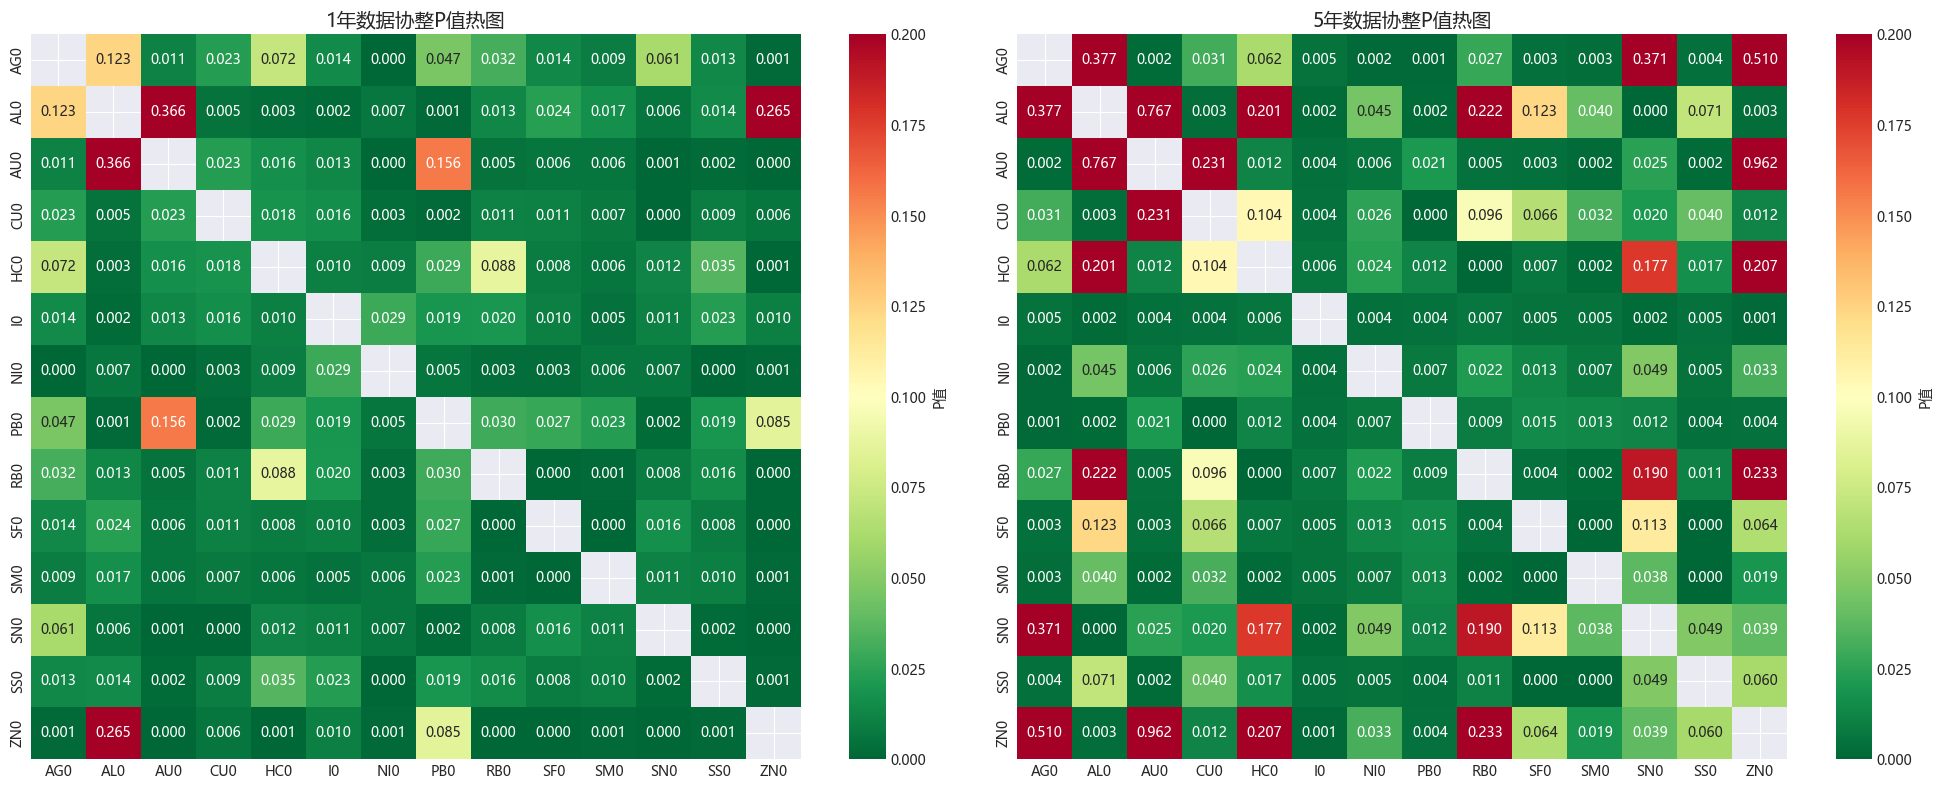

说明: 绿色=强协整(p<0.05), 黄色=弱协整, 红色=无协整


In [8]:
# 创建p值矩阵
def create_pvalue_matrix(results_df, symbols, pvalue_col):
    n = len(symbols)
    matrix = np.ones((n, n))
    
    for _, row in results_df.iterrows():
        i = symbols.index(row['symbol1'])
        j = symbols.index(row['symbol2'])
        pvalue = row[pvalue_col]
        matrix[i, j] = pvalue
        matrix[j, i] = pvalue
    
    return matrix

# 创建1年和5年的p值矩阵
pvalue_matrix_1y = create_pvalue_matrix(all_pairs_results, SYMBOLS, 'pvalue_1y')
pvalue_matrix_5y = create_pvalue_matrix(all_pairs_results, SYMBOLS, 'pvalue_5y')

# 绘制热图
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1年热图
sns.heatmap(pvalue_matrix_1y, 
            xticklabels=SYMBOLS,
            yticklabels=SYMBOLS,
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn_r',
            vmin=0, vmax=0.2,
            cbar_kws={'label': 'P值'},
            mask=np.eye(len(SYMBOLS), dtype=bool),
            ax=axes[0])
axes[0].set_title('1年数据协整P值热图', fontsize=14)

# 5年热图
sns.heatmap(pvalue_matrix_5y, 
            xticklabels=SYMBOLS,
            yticklabels=SYMBOLS,
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn_r',
            vmin=0, vmax=0.2,
            cbar_kws={'label': 'P值'},
            mask=np.eye(len(SYMBOLS), dtype=bool),
            ax=axes[1])
axes[1].set_title('5年数据协整P值热图', fontsize=14)

plt.tight_layout()
plt.show()

print("说明: 绿色=强协整(p<0.05), 黄色=弱协整, 红色=无协整")

## 3. 滚动窗口分析（p值筛选）

In [9]:
# 基于5年p值筛选配对
selected_pairs = all_pairs_results[all_pairs_results['pvalue_5y'] < P_THRESHOLD].copy()

print(f"P值筛选结果（阈值={P_THRESHOLD}）:")
print(f"  满足条件的配对: {len(selected_pairs)}个")
print(f"  占比: {len(selected_pairs)/91*100:.1f}%")

if len(selected_pairs) > 0:
    print(f"\n筛选出的配对列表:")
    for idx, row in selected_pairs.iterrows():
        print(f"  {row['pair']}: p_5y={row['pvalue_5y']:.4f}, HL_5y={row['halflife_5y']:.1f}天")
else:
    print("\n没有配对满足筛选条件")

P值筛选结果（阈值=0.05）:
  满足条件的配对: 70个
  占比: 76.9%

筛选出的配对列表:
  AG0-AU0: p_5y=0.0018, HL_5y=45.3天
  AG0-CU0: p_5y=0.0310, HL_5y=113.9天
  AG0-I0: p_5y=0.0049, HL_5y=49.1天
  AG0-NI0: p_5y=0.0015, HL_5y=44.4天
  AG0-PB0: p_5y=0.0010, HL_5y=29.1天
  AG0-RB0: p_5y=0.0274, HL_5y=74.2天
  AG0-SF0: p_5y=0.0035, HL_5y=50.2天
  AG0-SM0: p_5y=0.0030, HL_5y=46.9天
  AG0-SS0: p_5y=0.0037, HL_5y=46.4天
  AL0-CU0: p_5y=0.0030, HL_5y=46.2天
  AL0-I0: p_5y=0.0016, HL_5y=40.1天
  AL0-NI0: p_5y=0.0453, HL_5y=99.9天
  AL0-PB0: p_5y=0.0017, HL_5y=56.8天
  AL0-SM0: p_5y=0.0404, HL_5y=83.2天
  AL0-SN0: p_5y=0.0001, HL_5y=26.2天
  AL0-ZN0: p_5y=0.0028, HL_5y=41.3天
  AU0-HC0: p_5y=0.0122, HL_5y=67.8天
  AU0-I0: p_5y=0.0037, HL_5y=46.4天
  AU0-NI0: p_5y=0.0062, HL_5y=62.6天
  AU0-PB0: p_5y=0.0207, HL_5y=53.0天
  AU0-RB0: p_5y=0.0045, HL_5y=51.0天
  AU0-SF0: p_5y=0.0034, HL_5y=54.2天
  AU0-SM0: p_5y=0.0021, HL_5y=45.0天
  AU0-SN0: p_5y=0.0248, HL_5y=111.4天
  AU0-SS0: p_5y=0.0022, HL_5y=48.2天
  CU0-I0: p_5y=0.0042, HL_5y=47.4天
  CU0-NI0: 

In [10]:
# 对筛选出的配对进行滚动窗口分析
if len(selected_pairs) > 0:
    print(f"开始对{len(selected_pairs)}个配对进行滚动窗口分析...")
    
    rolling_results = batch_rolling_analysis(
        data_1y, 
        all_pairs_results,
        p_threshold=P_THRESHOLD
    )
    
    print(f"\n滚动分析完成")
    print(f"分析的配对: {list(rolling_results.keys())}")
else:
    print("没有配对需要进行滚动分析")
    rolling_results = {}

2025-08-19 08:12:02,742 - INFO - Selected 70 pairs with p<0.05
2025-08-19 08:12:02,744 - INFO - Rolling analysis for AG0-AU0
2025-08-19 08:12:02,852 - INFO - Rolling analysis for AG0-CU0


开始对70个配对进行滚动窗口分析...


2025-08-19 08:12:03,010 - INFO - Rolling analysis for AG0-I0
2025-08-19 08:12:03,159 - INFO - Rolling analysis for AG0-NI0
2025-08-19 08:12:03,292 - INFO - Rolling analysis for AG0-PB0
2025-08-19 08:12:03,402 - INFO - Rolling analysis for AG0-RB0
2025-08-19 08:12:03,537 - INFO - Rolling analysis for AG0-SF0
2025-08-19 08:12:03,671 - INFO - Rolling analysis for AG0-SM0
2025-08-19 08:12:03,798 - INFO - Rolling analysis for AG0-SS0
2025-08-19 08:12:03,923 - INFO - Rolling analysis for AL0-CU0
2025-08-19 08:12:04,054 - INFO - Rolling analysis for AL0-I0
2025-08-19 08:12:04,188 - INFO - Rolling analysis for AL0-NI0
2025-08-19 08:12:04,328 - INFO - Rolling analysis for AL0-PB0
2025-08-19 08:12:04,455 - INFO - Rolling analysis for AL0-SM0
2025-08-19 08:12:04,570 - INFO - Rolling analysis for AL0-SN0
2025-08-19 08:12:04,722 - INFO - Rolling analysis for AL0-ZN0
2025-08-19 08:12:04,835 - INFO - Rolling analysis for AU0-HC0
2025-08-19 08:12:04,969 - INFO - Rolling analysis for AU0-I0
2025-08-19 


滚动分析完成
分析的配对: ['AG0-AU0', 'AG0-CU0', 'AG0-I0', 'AG0-NI0', 'AG0-PB0', 'AG0-RB0', 'AG0-SF0', 'AG0-SM0', 'AG0-SS0', 'AL0-CU0', 'AL0-I0', 'AL0-NI0', 'AL0-PB0', 'AL0-SM0', 'AL0-SN0', 'AL0-ZN0', 'AU0-HC0', 'AU0-I0', 'AU0-NI0', 'AU0-PB0', 'AU0-RB0', 'AU0-SF0', 'AU0-SM0', 'AU0-SN0', 'AU0-SS0', 'CU0-I0', 'CU0-NI0', 'CU0-PB0', 'CU0-SM0', 'CU0-SN0', 'CU0-SS0', 'CU0-ZN0', 'HC0-I0', 'HC0-NI0', 'HC0-PB0', 'HC0-RB0', 'HC0-SF0', 'HC0-SM0', 'HC0-SS0', 'I0-NI0', 'I0-PB0', 'I0-RB0', 'I0-SF0', 'I0-SM0', 'I0-SN0', 'I0-SS0', 'I0-ZN0', 'NI0-PB0', 'NI0-RB0', 'NI0-SF0', 'NI0-SM0', 'NI0-SN0', 'NI0-SS0', 'NI0-ZN0', 'PB0-RB0', 'PB0-SF0', 'PB0-SM0', 'PB0-SN0', 'PB0-SS0', 'PB0-ZN0', 'RB0-SF0', 'RB0-SM0', 'RB0-SS0', 'SF0-SM0', 'SF0-SS0', 'SM0-SN0', 'SM0-SS0', 'SM0-ZN0', 'SN0-SS0', 'SN0-ZN0']


## 4. 滚动窗口结果展示

示例配对: AG0-AU0


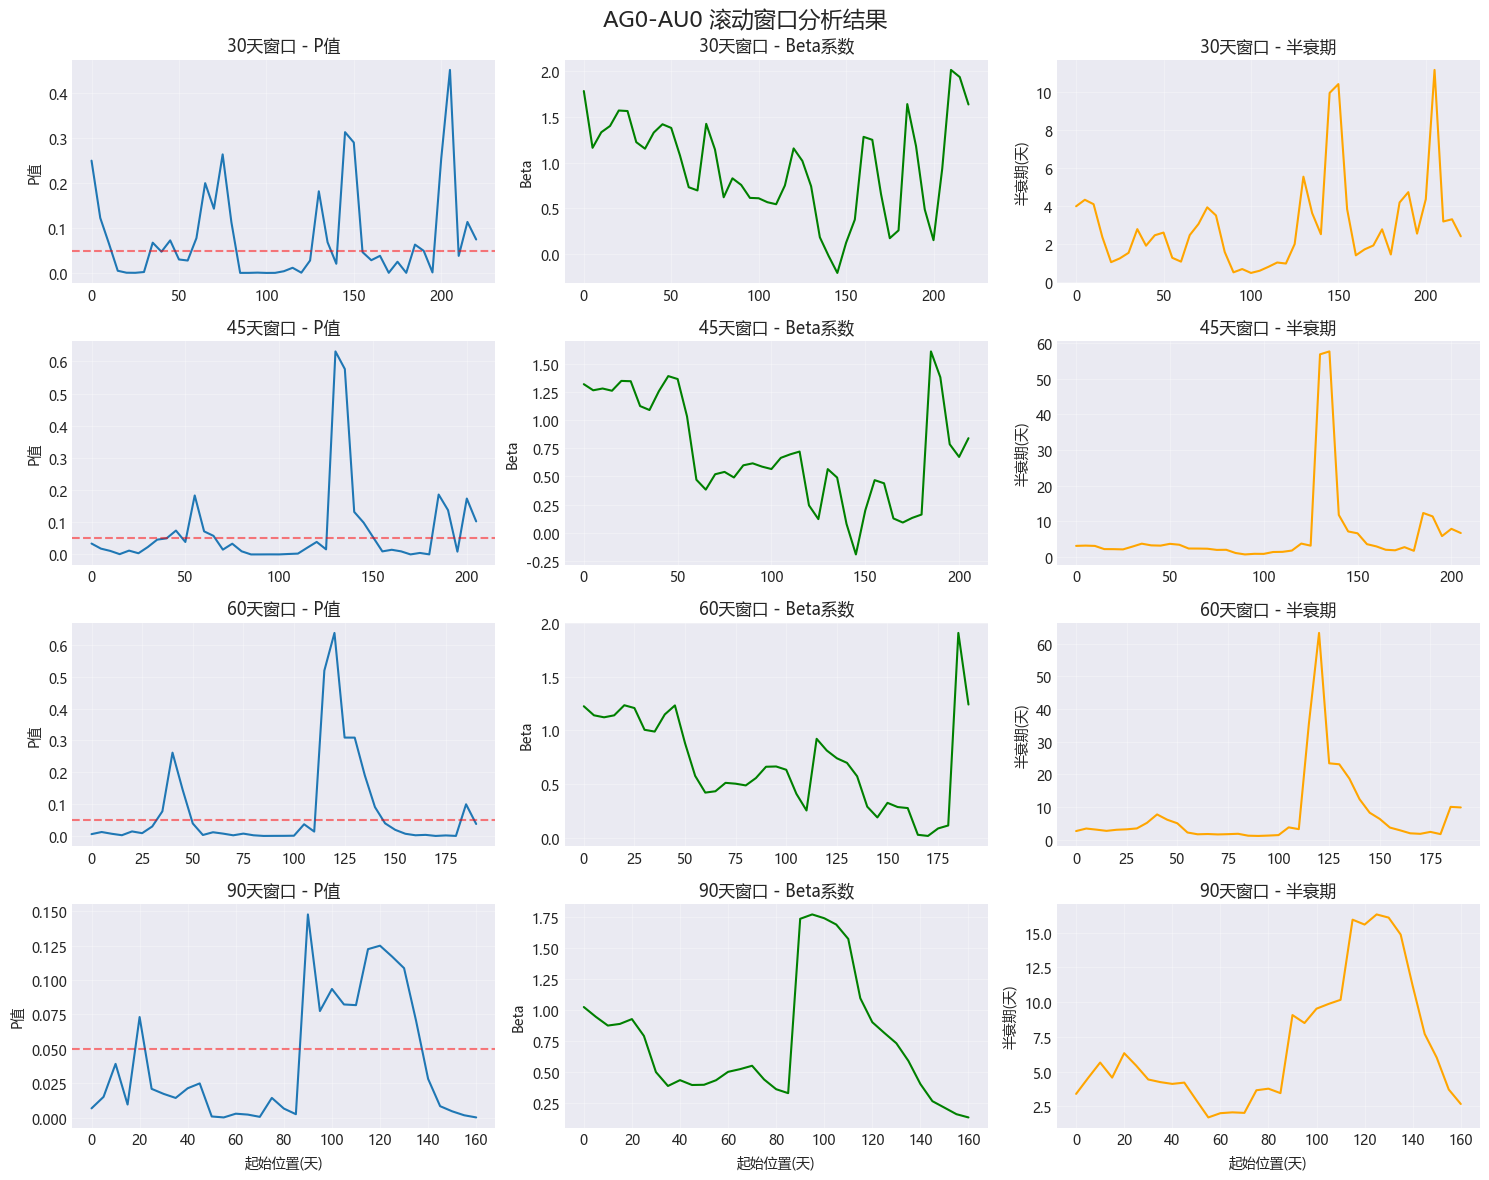

In [11]:
# 展示每个配对的滚动窗口结果
if rolling_results:
    # 选择第一个配对作为示例
    example_pair = list(rolling_results.keys())[0]
    example_data = rolling_results[example_pair]
    
    print(f"示例配对: {example_pair}")
    print("="*60)
    
    # 绘制4个窗口的结果
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    
    for idx, window in enumerate(WINDOW_SIZES):
        key = f'window_{window}'
        data = example_data[key]
        time_axis = data['window_starts']
        
        # P值
        axes[idx, 0].plot(time_axis, data['pvalues'])
        axes[idx, 0].axhline(y=0.05, color='r', linestyle='--', alpha=0.5)
        axes[idx, 0].set_ylabel('P值')
        axes[idx, 0].set_title(f'{window}天窗口 - P值')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Beta
        axes[idx, 1].plot(time_axis, data['betas'], color='green')
        axes[idx, 1].set_ylabel('Beta')
        axes[idx, 1].set_title(f'{window}天窗口 - Beta系数')
        axes[idx, 1].grid(True, alpha=0.3)
        
        # 半衰期
        axes[idx, 2].plot(time_axis, data['halflifes'], color='orange')
        axes[idx, 2].set_ylabel('半衰期(天)')
        axes[idx, 2].set_title(f'{window}天窗口 - 半衰期')
        axes[idx, 2].grid(True, alpha=0.3)
        
        if idx == 3:
            axes[idx, 0].set_xlabel('起始位置(天)')
            axes[idx, 1].set_xlabel('起始位置(天)')
            axes[idx, 2].set_xlabel('起始位置(天)')
    
    plt.suptitle(f'{example_pair} 滚动窗口分析结果', fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
# 滚动窗口汇总统计
if rolling_results:
    summary_all = []
    
    for pair_name, pair_data in rolling_results.items():
        for window in WINDOW_SIZES:
            key = f'window_{window}'
            data = pair_data[key]
            
            # 计算统计量
            valid_p = data['pvalues'][~np.isnan(data['pvalues'])]
            valid_beta = data['betas'][~np.isnan(data['betas'])]
            valid_hl = data['halflifes'][~np.isnan(data['halflifes'])]
            
            summary_all.append({
                '配对': pair_name,
                '窗口': window,
                'P值均值': np.mean(valid_p) if len(valid_p) > 0 else np.nan,
                'P值最小': np.min(valid_p) if len(valid_p) > 0 else np.nan,
                'P值最大': np.max(valid_p) if len(valid_p) > 0 else np.nan,
                'Beta均值': np.mean(valid_beta) if len(valid_beta) > 0 else np.nan,
                'Beta标准差': np.std(valid_beta) if len(valid_beta) > 0 else np.nan,
                '半衰期均值': np.mean(valid_hl) if len(valid_hl) > 0 else np.nan,
                '显著比例': (valid_p < 0.05).mean() if len(valid_p) > 0 else 0
            })
    
    summary_df = pd.DataFrame(summary_all)
    
    print("\n滚动窗口分析汇总统计:")
    print("="*100)
    print(summary_df.round(4).to_string(index=False))


滚动窗口分析汇总统计:
     配对  窗口   P值均值   P值最小   P值最大  Beta均值  Beta标准差   半衰期均值   显著比例
AG0-AU0  30 0.0799 0.0000 0.4524  0.9466   0.5376  2.9684 0.5778
AG0-AU0  45 0.0691 0.0000 0.6312  0.7172   0.4609  6.1697 0.6667
AG0-AU0  60 0.0758 0.0000 0.6381  0.6909   0.4263  7.5146 0.7436
AG0-AU0  90 0.0406 0.0000 0.1477  0.7442   0.4753  6.8415 0.6667
AG0-CU0  30 0.0713 0.0003 0.5481  1.1621   1.0465  2.4159 0.6889
AG0-CU0  45 0.0655 0.0000 0.3618  1.1662   0.6500  3.4400 0.6429
AG0-CU0  60 0.0549 0.0001 0.4979  1.2080   0.5421  4.3634 0.6154
AG0-CU0  90 0.0652 0.0000 0.4113  1.0562   0.2854  7.2314 0.6970
 AG0-I0  30 0.1178 0.0000 0.7650  0.5261   0.6919  2.5547 0.4222
 AG0-I0  45 0.0970 0.0000 0.6268  0.5237   0.5563  5.2588 0.6667
 AG0-I0  60 0.1282 0.0001 0.6176  0.3890   0.3496  8.0524 0.5128
 AG0-I0  90 0.0958 0.0002 0.4854  0.1484   0.4693  8.8461 0.5152
AG0-NI0  30 0.0873 0.0005 0.3695  0.2639   0.7129  3.1643 0.4444
AG0-NI0  45 0.0925 0.0011 0.5431  0.2177   0.6731  5.5330 0.5714
AG0-NI0  60 

## 5. 导出结果

In [ ]:
# 保存结果
from pathlib import Path

output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)

# 保存所有配对结果
output_file = output_dir / f"cointegration_all_pairs_{datetime.now().strftime('%Y%m%d')}.csv"
all_pairs_results.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"所有配对结果已保存: {output_file}")

# 保存滚动分析汇总
if 'summary_df' in locals():
    summary_file = output_dir / f"rolling_summary_{datetime.now().strftime('%Y%m%d')}.csv"
    summary_df.to_csv(summary_file, index=False, encoding='utf-8-sig')
    print(f"滚动分析汇总已保存: {summary_file}")